<a href="https://colab.research.google.com/github/trong-khanh-1109/CS114.L22.KHCL/blob/main/Sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><b>BÀI TẬP COLAB SỐ 04</b></h1>
<h1 align="center"><b>Sarcasm detection in news headline</b></h1>

###LỚP: CS114.L21.KHCL-CS114.L22.KHCL
###NHÓM:
1. Đỗ Trọng Khánh - *19521676*
2. Võ Phạm Duy Đức - *19521383*
3. Trịnh Công Danh - *19521326*

#**I. Import thư viện cần thiết**

In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report

from keras import models, layers, optimizers, losses, callbacks

#**II. Dataset**

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Tin châm biếm
df_sarcasm_1 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Sarcasm/betoota.csv')
df_sarcasm_2 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Sarcasm/thehardtimes.csv')
df_sarcasm_3 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Sarcasm/thepoke.csv')
# Tin không châm biếm
df_not_sarcasm_1 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Not_Sarcasm/citynews.csv')
df_not_sarcasm_2 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Not_Sarcasm/fortune.csv')
df_not_sarcasm_3 = pd.read_csv('/content/drive/My Drive/Sarcasm_detection/Not_Sarcasm/thenewyork.csv')

In [25]:
# Nối các file châm biếm thành 1 file
df_sarcasm = df_sarcasm_1.append(df_sarcasm_2, sort = True)
df_sarcasm = df_sarcasm.append(df_sarcasm_3, sort = True)
# Nối các file không châm biếm thành 1 file
df_not_sarcasm = df_not_sarcasm_1.append(df_not_sarcasm_2, sort = True)
df_not_sarcasm = df_not_sarcasm.append(df_not_sarcasm_3, sort = True)

In [26]:
df = df_not_sarcasm.append(df_sarcasm, sort = True)
df

,article_link,headline,is_sarcastic
0,https://toronto.citynews.ca/2021/06/09/a-look-...,A look at COVID-19 vaccinations in Canada on W...,0
1,https://toronto.citynews.ca/2021/06/09/the-lat...,The latest numbers on COVID-19 in Canada for W...,0
2,https://toronto.citynews.ca/2021/06/09/b-c-app...,B.C. approves First Nations’ request to defer ...,0
3,https://toronto.citynews.ca/2021/06/09/northwe...,Northwest Territories launches reopening plan ...,0
4,https://toronto.citynews.ca/2021/06/09/report-...,Report says Canada needs to bolster plane cert...,0
...,...,...,...
12281,https://www.thepoke.co.uk/2018/05/02/best-camp...,Best campaign leaflet you’ll see this election,1
12282,https://www.thepoke.co.uk/2018/05/01/most-brut...,The most brutal ‘friend zoning’ of anyone you’...,1
12283,https://www.thepoke.co.uk/2018/05/01/someones-...,Someone’s collecting the most creative ways pe...,1
12284,https://www.thepoke.co.uk/2018/05/01/matthew-w...,Matthew Wright’s leaving The Wright Stuff so l...,1


In [27]:
# Xáo trộn dữ liệu trong df
df = df.sample(frac=1).reset_index(drop=True)
df

,article_link,headline,is_sarcastic
0,https://www.thepoke.co.uk/2020/08/06/accidenta...,The ‘accidentally left-wing’ Twitter account s...,1
1,https://thehardtimes.net/blog/we-interviewed-t...,We Interviewed the Wrong Dave Matthews but Now...,1
2,https://thehardtimes.net/blog/we-ranked-the-to...,We Ranked the Top 10 Amazing Things You Could ...,1
3,https://toronto.citynews.ca/2020/06/13/quebec-...,Quebec provincial police searching for armed m...,0
4,https://fortune.com/2019/10/21/renewables-sola...,Plunging Costs Make Solar the Renewables Leade...,0
...,...,...,...
41871,https://toronto.citynews.ca/2019/12/05/supreme...,Supreme Court won’t hear appeal from former Na...,0
41872,https://toronto.citynews.ca/2021/01/23/could-a...,Could a psychedelic gold rush be on the horizon?,0
41873,https://www.thepoke.co.uk/2019/01/09/keep-eye-...,Keep your eye on the big road sign because thi...,1
41874,https://www.thepoke.co.uk/2018/07/26/this-mast...,This masterclass in dealing with scammers is t...,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41876 entries, 0 to 41875
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  41876 non-null  object
 1   headline      41876 non-null  object
 2   is_sarcastic  41876 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 981.6+ KB


#**III. Tiền xử lý dữ liệu**

In [29]:
def get_sequences(texts, tokenizer, train = True, max_seq_length = None):
  sequences = tokenizer.texts_to_sequences(texts) # Ánh xạ mỗi từ của 1 câu qua số nguyên dương
  # Các câu đều có độ dài khác nhau nên bước tiếp theo chúng ta cần đưa chúng về cùng độ dài với độ dài là độ dài max của một chuỗi

  if train == True:
    max_seq_length = np.max(list(map(len, sequences)))  # Tìm chuỗi có độ dài lớn nhất
  sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen = max_seq_length, padding = 'post') # Đưa các câu về cùng độ dài
  return sequences

In [30]:
def preprocess_inputs(df):
  df = df.copy()
  # Xóa cột article_link
  df = df.drop('article_link', axis = 1)
  # 
  X = df['headline']
  y = df['is_sarcastic']
  # Chia tập dữ liệu train test
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = True, random_state = 1)
  # Tạo và fit tokenizer
  tokenizer = tf.keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(X_train)
  print("Số lượng từ :", len(tokenizer.word_index) + 1) # Các từ được sắp xếp từ trên xuống theo tần xuất xuất hiện
  # get sequences data
  X_train = get_sequences(texts = X_train, tokenizer = tokenizer, train = True)
  X_test = get_sequences(texts = X_test, tokenizer = tokenizer, train = False, max_seq_length = X_train.shape[1])
  print("Độ dài của câu: ", X_train.shape[1])
  return X_train, X_test, y_train, y_test

#**VI. Chia tập dữ liệu train test**

In [31]:
X_train, X_test, y_train, y_test = preprocess_inputs(df)

Số lượng từ : 28642
Độ dài của câu:  76


In [32]:
X_train

array([[   64,  1882,  1411, ...,     0,     0,     0],
       [   75,   417,     3, ...,     0,     0,     0],
       [  867,   418,  1170, ...,     0,     0,     0],
       ...,
       [  211,    73,  5098, ...,     0,     0,     0],
       [ 3498, 28639,   851, ...,     0,     0,     0],
       [  561,    40, 28641, ...,     0,     0,     0]], dtype=int32)

In [33]:
y_train.value_counts()

0    15118
1    14195
Name: is_sarcastic, dtype: int64

In [34]:
X_test

array([[ 9172,   907,   853, ...,     0,     0,     0],
       [    9,   701,    48, ...,     0,     0,     0],
       [   90,     4,   281, ...,     0,     0,     0],
       ...,
       [ 2246,    56, 12560, ...,     0,     0,     0],
       [  122,   386,  4761, ...,     0,     0,     0],
       [  412,    44,   309, ...,     0,     0,     0]], dtype=int32)

In [35]:
y_test

1785     1
5104     1
8850     0
12585    0
15937    1
        ..
41451    1
31192    0
22860    0
32065    0
33359    0
Name: is_sarcastic, Length: 12563, dtype: int64

In [36]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train

array([[   64,  1882,  1411, ...,     0,     0,     0],
       [   75,   417,     3, ...,     0,     0,     0],
       [  867,   418,  1170, ...,     0,     0,     0],
       ...,
       [  211,    73,  5098, ...,     0,     0,     0],
       [ 3498, 28639,   851, ...,     0,     0,     0],
       [  561,    40, 28641, ...,     0,     0,     0]], dtype=int32)

#**V. Tạo model**

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(28930, 16, input_length=40),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 16)            462880    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 465,185
Trainable params: 465,185
Non-trainable params: 0
_________________________________________________________________


#**VI. Training**

In [39]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=2)

Epoch 1/30
917/917 - 6s - loss: 0.3359 - accuracy: 0.8419 - val_loss: 0.1406 - val_accuracy: 0.9469
Epoch 2/30
917/917 - 5s - loss: 0.0921 - accuracy: 0.9682 - val_loss: 0.1059 - val_accuracy: 0.9599
Epoch 3/30
917/917 - 5s - loss: 0.0522 - accuracy: 0.9828 - val_loss: 0.0969 - val_accuracy: 0.9646
Epoch 4/30
917/917 - 5s - loss: 0.0302 - accuracy: 0.9907 - val_loss: 0.1045 - val_accuracy: 0.9619
Epoch 5/30
917/917 - 5s - loss: 0.0184 - accuracy: 0.9949 - val_loss: 0.1053 - val_accuracy: 0.9647
Epoch 6/30
917/917 - 5s - loss: 0.0104 - accuracy: 0.9976 - val_loss: 0.1129 - val_accuracy: 0.9638
Epoch 7/30
917/917 - 5s - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.1314 - val_accuracy: 0.9610
Epoch 8/30
917/917 - 6s - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.2025 - val_accuracy: 0.9486
Epoch 9/30
917/917 - 5s - loss: 0.0018 - accuracy: 0.9999 - val_loss: 0.1504 - val_accuracy: 0.9609
Epoch 10/30
917/917 - 5s - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1918 - val_accuracy: 0.9569

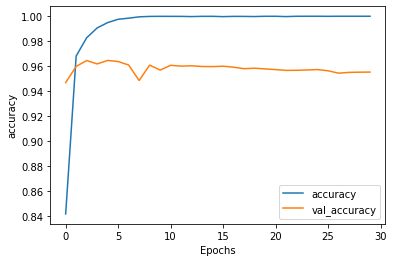

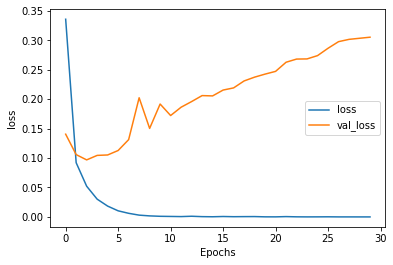

In [40]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Accuracy: 95.53%


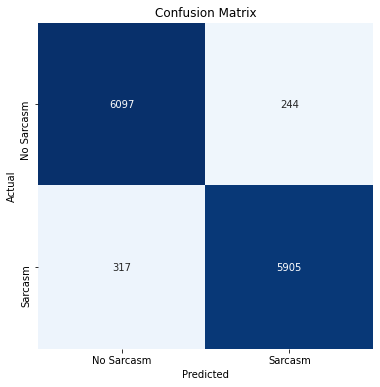

Classification Report:
----------------------
               precision    recall  f1-score   support

  No Sarcasm       0.95      0.96      0.96      6341
     Sarcasm       0.96      0.95      0.95      6222

    accuracy                           0.96     12563
   macro avg       0.96      0.96      0.96     12563
weighted avg       0.96      0.96      0.96     12563



In [41]:
results = model.evaluate(X_test, y_test, verbose=0)
#print(results)
print("Accuracy: {:.2f}%".format(results[1] * 100))

y_pred = np.squeeze(model.predict(X_test) >= 0.5).astype(np.int)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
clr = classification_report(y_test, y_pred, labels=[0, 1], target_names=["No Sarcasm", "Sarcasm"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Sarcasm", "Sarcasm"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

#**VII. Dự đoán một tiêu đề bất kỳ**

In [42]:
class_names = ['Not sarcastic', 'Sarcastic']


In [100]:
test = df[0:10]
print("================= Bộ test ==================")
print(test[['headline', 'is_sarcastic']])
result = test[['headline', 'is_sarcastic']]
headline_test = test['headline']
headline_label = test['is_sarcastic']
#print(headline_test)
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(headline_test)

headline_test = tokenizer.texts_to_sequences(headline_test)

headline_test = pad_sequences(headline_test, maxlen=18, padding='post')
headline_test
output = model.predict(headline_test)
pred = (output>0.5).astype('int64')
result['result_predict'] = pred
print("================= Kết quả sau khi predict ==================")
print(result)

================= Bộ test ==================
                                            headline  is_sarcastic
0  The ‘accidentally left-wing’ Twitter account s...             1
1  We Interviewed the Wrong Dave Matthews but Now...             1
2  We Ranked the Top 10 Amazing Things You Could ...             1
3  Quebec provincial police searching for armed m...             0
4  Plunging Costs Make Solar the Renewables Leade...             0
5  Greta Thunberg’s takedown of Donald Trump was ...             1
6  Local Hedonist Repairs Damage Done Over The We...             1
7  Canadian health officials urge rally-goers to ...             0
8  Trapt Issues “Start and Persist” Letter Urging...             1
9  Ontario stay-at-home order; Biden takes aim at...             0
================= Kết quả sau khi predict ==================
                                            headline  ...  result_predict
0  The ‘accidentally left-wing’ Twitter account s...  ...               1
1  We Int

#**VIII. Nhận xét:**
 - Theo biểu đồ ở mục VII ta thấy accuracy là rất cao (95.53%) nên model sử dụng cho bài toán này là tốt
 - Sau khi chạy thử 10 tiêu đề cho kết quả đúng 6/10 

#**IX. Tài liệu tham khảo**
- https://www.kaggle.com/gcdatkin/news-headline-sarcasm-detection
- https://cainvas.ai-tech.systems/use-cases/sarcasm-detection-app-for-news-headlines/#Visualization